<a href="https://colab.research.google.com/github/hawc2/wikidata/blob/main/Wikidata_SPARQL_Queries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Querying and Visualizing Wikidata Overview




## Instructions

This notebook guides you through querying and visualizing wikidata.

# Install Packages

In [ ]:
!pip install SPARQLWrapper
%load_ext google.colab.data_table 
import sys
from SPARQLWrapper import SPARQLWrapper, JSON
import pandas as pd
sparql = SPARQLWrapper("https://query.wikidata.org/sparql")

     |████████████████████████████████| 376 kB 2.5 MB/s 
     |████████████████████████████████| 45 kB 4.3 MB/s 


# Get Your Data

Using Sparqlwrapper Query Wikidata API

## Set up SPARQL Query

### Relevant Data

https://docs.google.com/spreadsheets/d/1grYsGIwp6yey0ZPdkFXJlzlwZSQ6-4mRHO2XoZYicSQ/edit#gid=0

### Potential Additions

addiohng more variables social media and website info? who doesn't have this info?

are there other institutiosn that hold these artists? like detroit / michigan artists connections with philly? what connections do philly artists have with other cities, artists outside philly?

tracing familial and professional connections; 'trained by, influenced by' family connections to other regions
regional cultural background

network connections - significant person field? captures people who were peers, colleagues, if people exhibited together - artists who collaborated together?

no field being used often for 'exhibiting' - 'has works in collection' is a consistent field, but not much individual gallery shows-events

what about sexual orientation/identity?

can we complicate how we're defining ethnicity? synatra has some other properties

In [ ]:
sparql.setQuery("""
SELECT
    ?artist ?artistLabel ?sexGenderLabel ?birthdayLabel ?deathDateLabel
    (group_concat(DISTINCT(?occupationLabel);separator=", ") as ?occupations)
    (group_concat(DISTINCT(?residenceLabel);separator=", ") as ?residences)
    (group_concat(DISTINCT(?educationLabel);separator=", ") as ?educations)
    (group_concat(DISTINCT(?employerLabel);separator=", ") as ?employers)
    (group_concat(DISTINCT(?birthPlaceLabel);separator=", ") as ?birthPlaces)
    (group_concat(DISTINCT(?deathPlaceLabel);separator=", ") as ?deathPlaces)
    
WHERE
{
    ?artist wdt:P5008 wd:Q94124522. # PMA African American artists
    ?artist wdt:P106 ?occupation
    OPTIONAL { ?artist wdt:P21 ?sexGender. }
    OPTIONAL { ?artist wdt:P569 ?birthdayLabel. }
    OPTIONAL { ?artist wdt:P570 ?deathDateLabel. }
    OPTIONAL { ?artist wdt:P19 ?birthPlace. }
    OPTIONAL { ?artist wdt:P20 ?deathPlace. }
    OPTIONAL { ?artist wdt:P551 ?residence. }
    OPTIONAL { ?artist wdt:P69 ?education. }
    OPTIONAL { ?artist wdt:P108 ?employer. }
    SERVICE wikibase:label { 
    bd:serviceParam wikibase:language "en". 
    ?artist rdfs:label ?artistLabel . 
    ?occupation rdfs:label ?occupationLabel .
    ?sexGender rdfs:label ?sexGenderLabel .
    ?birthPlace rdfs:label ?birthPlaceLabel .
    ?deathPlace rdfs:label ?deathPlaceLabel .
    ?residence rdfs:label ?residenceLabel .
    ?education rdfs:label ?educationLabel .
    ?employer rdfs:label ?employerLabel .
  }
}
GROUP BY ?artist ?artistLabel ?sexGenderLabel ?birthdayLabel ?deathDateLabel
ORDER BY ?artistLabel
""")

In [ ]:
sparql.setReturnFormat(JSON)
results = sparql.query().convert()


In [ ]:
results

# Wrangle your Data

## Jay's Homework

Why do we have multiple records/rows for some artists? 
John Woodrow Wilson for instance
Concatenate more fields

let's also think about standardizing null values NaN or blank

birthdate/deathdate values could also be simplified and clarified, doesnt' look like time is worth keeping

return to question of addresses not really containing accurate geographical info. it sounds best would be to update the sparql query


we could use python and regex to break down some fields into multiple columns per data point. for first name and last name could be generated in another way from spraql properties in wikidata

## Rebecca's Homework



## Create Dataframe


In [ ]:
df = pd.io.json.json_normalize(results['results']['bindings'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """Entry point for launching an IPython kernel.


In [ ]:
cols = ['artistLabel.value', 
            'sexGenderLabel.value', 
            'birthdayLabel.value',
            'deathDateLabel.value',
            'birthPlaces.value',
            'deathPlaces.value',
            'residences.value',
            'educations.value',
            'occupations.value',
            'employers.value']

In [ ]:
df = df[cols]

In [ ]:
df.columns = ['name', 'gender', 'birthdate', 'deathdate', 'birthplace', 'deathplace', 'residence', 'education', 'occupation', 'employer']
df

,name,gender,birthdate,deathdate,birthplace,deathplace,residence,education,occupation,employer
0,A.J. Smith,male,1952-01-01T00:00:00Z,NaN,,,,,"professor, artist, printmaker",University of Arkansas at Little Rock
1,Aaron Douglas,male,1899-05-26T00:00:00Z,1979-02-02T00:00:00Z,Topeka,1979-02-02T00:00:00Z,,"University of Kansas, University of Nebraska–L...","illustrator, painter, muralist",Fisk University
2,Akili Ron Anderson,male,1946-02-19T00:00:00Z,NaN,"Washington, D.C.",,"Washington, D.C.",Howard University,"photographer, artist, painter, sculptor, stain...",
3,Alfred A. Smith,male,1896-09-17T00:00:00Z,1940-01-01T00:00:00Z,New York City,1940-01-01T00:00:00Z,"New York City, Paris",,artist,
4,Alison Saar,female,1956-02-05T00:00:00Z,NaN,Los Angeles,,,"Otis College of Art and Design, Scripps College","photographer, artist, illustrator, painter, sc...",
...,...,...,...,...,...,...,...,...,...,...
220,William Majors,male,1930-07-21T00:00:00Z,1982-08-29T00:00:00Z,Indianapolis,1982-08-29T00:00:00Z,,Herron School of Art and Design,"artist, university teacher",
221,William Plummer,male,1873-01-01T00:00:00Z,1943-01-01T00:00:00Z,,1943-01-01T00:00:00Z,Smyth County,,"inventor, cabinetmaker",
222,William T. Williams,male,1942-07-17T00:00:00Z,NaN,Cross Creek Township,,,"Yale University, Pratt Institute, Yale School ...","professor, artist, painter, printmaker",Brooklyn College
223,Willie Birch,male,1942-01-01T00:00:00Z,NaN,New Orleans,,New Orleans,"Southern University, Maryland Institute Colleg...","artist, university teacher",Touro College


In [ ]:
## Gathering duplicate entries so I can figure out which columns still need to be concatenated.
dupe = df[df.duplicated(subset=['name'], keep=False)]
dupe

,name,gender,birthdate,deathdate,birthplace,deathplace,residence,education,occupation,employer
17,Beauford Delaney,male,1901-12-30T00:00:00Z,1979-03-25T00:00:00Z,Knoxville,1979-03-25T00:00:00Z,,"Harvard University, Austin-East High School",painter,
18,Beauford Delaney,male,1901-12-31T00:00:00Z,1979-03-25T00:00:00Z,Knoxville,1979-03-25T00:00:00Z,,"Harvard University, Austin-East High School",painter,
19,Beauford Delaney,male,1901-12-30T00:00:00Z,1979-03-26T00:00:00Z,Knoxville,1979-03-26T00:00:00Z,,"Harvard University, Austin-East High School",painter,
20,Beauford Delaney,male,1901-12-31T00:00:00Z,1979-03-26T00:00:00Z,Knoxville,1979-03-26T00:00:00Z,,"Harvard University, Austin-East High School",painter,
34,Charles Wilbert White,male,1918-04-02T00:00:00Z,1979-10-03T00:00:00Z,Chicago,1979-10-03T00:00:00Z,,School of the Art Institute of Chicago,"artist, painter, printmaker",
35,Charles Wilbert White,male,1918-04-02T00:00:00Z,1979-11-03T00:00:00Z,Chicago,1979-11-03T00:00:00Z,,School of the Art Institute of Chicago,"artist, painter, printmaker",
69,Gertrude Morgan,female,1900-04-07T00:00:00Z,1980-07-08T00:00:00Z,LaFayette,1980-07-08T00:00:00Z,"New Orleans, LaFayette, Columbus",,"missionary, preacher, artist, musician, painte...",
70,Gertrude Morgan,female,1900-01-01T00:00:00Z,1980-07-08T00:00:00Z,LaFayette,1980-07-08T00:00:00Z,"New Orleans, LaFayette, Columbus",,"poet, missionary, preacher, artist, musician, ...",
79,Henry Ossawa Tanner,male,1859-06-21T00:00:00Z,1937-05-24T00:00:00Z,Pittsburgh,1937-05-24T00:00:00Z,Henry O. Tanner House,"Académie Julian, Pennsylvania Academy of the F...","university teacher, printmaker, photographer, ...",Clark University
80,Henry Ossawa Tanner,male,1859-06-21T00:00:00Z,1937-05-25T00:00:00Z,Pittsburgh,1937-05-25T00:00:00Z,Henry O. Tanner House,"Académie Julian, Pennsylvania Academy of the F...","photographer, painter, university teacher, pri...",Clark University


In [ ]:
dupe.to_csv(r'Dupe.csv', index = True)
from google.colab import files 

## Cleaning the Data Frame

This includes alot of the ideas in the comments on the site

## Download Data as CSV

In [ ]:
df.to_csv(r'Wikidata.csv', index = True)

In [ ]:
from google.colab import files
files.download('Wikidata.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Visualize Your Data

# Sample Visualization

https://towardsdatascience.com/where-do-mayors-come-from-querying-wikidata-with-python-and-sparql-91f3c0af22e2


# To Dos

Calculate length of lie by looking at birth and death data

Visualization of where they are born, and where they end up living
How many people lived or died somewhere different than they were born? 


TypeError: ignored

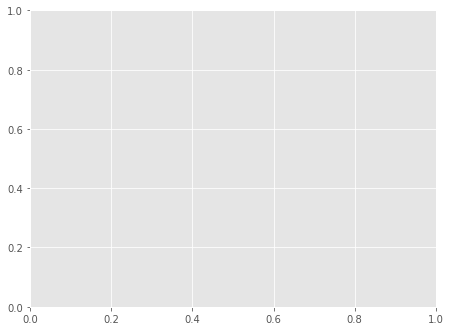

In [ ]:
# Adapt to our dataset:

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(16, 12))
for i, label in enumerate(['birthdate', 'deathdate', 'birthplace', 'deathplace']):
    plt.subplot(2, 2, i + 1)
    df_plot = df[label].sort_values().dropna()
    df_plot.plot(kind='barh', color='C0', ax=plt.gca());
    plt.ylabel('')
    plt.xticks(rotation=30)
    plt.title(label.capitalize())
    plt.ticklabel_format(style='plain', axis='x')
plt.tight_layout()

In [ ]:
#Alternative viz more advanced

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
df['age'].sort_values().plot(kind='barh', color='C0', title='Mayors Age')
plt.ylabel('')
plt.subplot(1, 2, 2)
df['population'].sort_values().plot(kind='barh', color='C0', title='Population')
plt.ylabel('')
plt.ticklabel_format(style='plain', axis='x')
plt.tight_layout()

In [ ]:
from geopy.distance import distancecoordinates = df[['capital_lon', 'capital_lat', 
                  'birth_place_lon', 'birth_place_lat']]
df['distance'] = [distance((lat0, lon0), (lat1, lon1)).m 
                for lon0, lat0, lon1, lat1 in coordinates.values]df['distance'].sort_values().plot(
    kind='barh', color='C0', logx=True)
plt.xlabel('Distance (m)')
plt.ylabel('');